## 3.1.1.Noise Detection and Filtering 부분 부터 이해할 것

In [1]:
ParaFolder = 'RawSet1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
from scipy import signal 
if 'ParaFolder' not in locals():
    print('ParaFolder No exist') 

# 1.1.1.Basic processing and Smoothing

#### Raw data (csv format) 경로 설정, 파일명 형태: "ID.csv" (ex: 1004.csv)

In [3]:
path = "../ProcessedData_VitalDB/"+str(ParaFolder)+"/"
file_list = os.listdir(path)

'''
fileIDX = pd.Series(file_list)
fileIDX.to_csv('./ProcessedData/'+ParaFolder+'/fileIDX.csv')
'''

"\nfileIDX = pd.Series(file_list)\nfileIDX.to_csv('./ProcessedData/'+ParaFolder+'/fileIDX.csv')\n"

#### Basic processing 수행
- ABP 값 25보다 작거나 200보다 크거나, Nan 값인 경우 제외
- 15분 이상 연속시계열이 확보되는 구간 만 선정
- RawSampleIDXList index 설명 - 0:Sample, 1:시작점, 2:끝점

In [4]:
Censoring= 100 *60 * 25 # 100 samples per a second, 60 seconds, 20 min 
DataSet = []
ErrorTracker = []
SampleInfo=[]
RawSampleIDXList = []

for iNum, i in enumerate(file_list[:]):
    
    print(iNum, ' :',i)
    Data = pd.read_csv(path+i).values[Censoring:-Censoring]
    
    
    # 25보다 작고, 200보다 크고, Nan 값 있는 index 선택
    ExcCriteria = np.where( (Data<25) | (Data>=200) | np.isnan(Data))[0] 
    ExcCriteria = np.concatenate([[0], ExcCriteria, [Data.shape[0]]])
    IndMaxDif = ExcCriteria[1:] - ExcCriteria[:-1]
    IndMaxDif_enough = np.where(IndMaxDif>100*60*15)[0] # 17 분이상 연속시계열 확보 구간 선정, 앞뒤 1분씩 buffer 하여 15분으로 구성

    
    if len(IndMaxDif_enough) <= 0: # OBS 확보 안되는 sample은 포함 시키지 않기
        print('Sample excluded due to small obs.')
        ErrorTracker.append(str(iNum)+' excluded due to small obs.')
        print()
        continue

    StartInd = ExcCriteria[IndMaxDif_enough][..., np.newaxis]  + 100*60 # 60초 buffer
    EndInd = ExcCriteria[IndMaxDif_enough+1][..., np.newaxis]  # 60초 buffer
    SelectedPeriod = np.concatenate([StartInd,EndInd], axis=-1)
    
    #SampleIDXVec = np.ones((SelectedPeriod.shape[0],1), dtype=np.int32)
    #SampleIDXVec *= int(re.findall(r'\d+', i)[0])
    SampleIDXVec = np.full((SelectedPeriod.shape[0],1), iNum)
    RawSampleIDX = np.concatenate([SampleIDXVec, (SelectedPeriod + Censoring)], axis=1)
    RawSampleIDXList.append(RawSampleIDX)

    
    for PeriodNum,Period in enumerate(SelectedPeriod):
        print('Sample-'+str(iNum)+'-'+str(PeriodNum))
        SampleInfo.append('Sample-'+str(iNum)+'-'+str(PeriodNum))
        
        LessCheck = len(np.where(Data[Period[0]:Period[1]]<25)[0])
        LargeCheck = len(np.where(Data[Period[0]:Period[1]]>=200)[0])
        NanCheck = len(np.where(np.isnan(Data[Period[0]:Period[1]]))[0])
        
        if ((LessCheck>0) | (LargeCheck>0) | (NanCheck>0)): # 로직 에러 검수
            print('Error Found')
            ErrorTracker.append('Logic error of sample-'+str(iNum)+'-'+str(PeriodNum))
        
        DataSet.append(Data[Period[0]:Period[1]])
   
    print()

#np.save('./ProcessedData/'+ParaFolder+'/SampleInfo.npy',SampleInfo)
#np.save('./ProcessedData/'+ParaFolder+'/ErrorTracker.npy',ErrorTracker)
#np.save('./ProcessedData/'+ParaFolder+'/DataSet.npy',DataSet)
#np.save('./ProcessedData/'+ParaFolder+'/RawSampleIDX_raw.npy',RawSampleIDXList)

0  : .ipynb_checkpoints


PermissionError: [Errno 13] Permission denied: '../ProcessedData_VitalDB/RawSet1/.ipynb_checkpoints'

#### Smoothing 하기
- Moving Average 기법적용 
- Hyper-parameter: Window Size


Data Load
<br> Basic processing 을 통해 1차 필터링 된 데이터를 바탕으로 MA 수행

In [5]:
DataSet = np.load('./ProcessedData/'+ParaFolder+'/DataSet.npy',allow_pickle = True)

FileNotFoundError: [Errno 2] No such file or directory: './ProcessedData/RawSet1/DataSet.npy'

In [7]:
SmDataSet = []
WinSize = 3

def Smoothing(SMData):
    ### Moving avg
    cumsum, moving_aves = [0], []
    
    for i, x in enumerate(SMData, 1):
        cumsum.append(cumsum[i-1] + x[0])
        if i>WinSize:
            
            moving_ave = (cumsum[i] - cumsum[i-WinSize])/WinSize
            moving_aves.append(moving_ave)
            
        else:
            moving_aves.append(x[0])
    return np.array(moving_aves, dtype=np.float32)


for idx, i in enumerate(DataSet[:]):
    
    print(idx)
    DataSmoothed = Smoothing(i[:])
    SmDataSet.append(DataSmoothed[:, np.newaxis])
    
#np.save('./ProcessedData/'+ParaFolder+'/SmData.npy',SmDataSet)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


KeyboardInterrupt: 

# 2.1.Peak and Valley Detection

In [7]:
DataSmoothed = np.load('../ProcessedData_VitalDB/'+ParaFolder+'/SmData.npy',allow_pickle = True)

In [ ]:
DataSmoothed = SmDataSet.copy()
del SmDataSet

In [8]:
len(DataSmoothed)

2940

In [7]:
def PeakValley (DetectData):
    
    # Peak part, 기울기가 음수로 바뀌는 구간 선택
    GradSignal = np.gradient(DetectData[:, 0])
    NegGradIDX = np.where(GradSignal<0)[0] 
    NegGradIDX = np.delete(NegGradIDX,np.where(NegGradIDX==0)) # idx 0의 경우 제외
    CandidatePeakIDX = NegGradIDX[GradSignal[NegGradIDX-1]>=0]
    
    # peak 간 abp 값 차이가 +-20 제외 3번 실행
    for i in range(3):
        DiffBtwPeak = DetectData[CandidatePeakIDX][1:] -DetectData[CandidatePeakIDX][:-1]
        ConditionSmaller = np.where(DiffBtwPeak < -20)[0] +1 # peak 간 abp 값 차이가 -20 제외, 이전 보다 30이 줄었다면 제외
        ConditionGreater= np.where(DiffBtwPeak > 20)[0] # peak 간 abp 값 차이가 +20 제외, 다음 보다 30이 작다면 제외
        DeletCondition = np.unique(np.concatenate([ConditionSmaller, ConditionGreater]))
        CandidatePeakIDX = np.delete(CandidatePeakIDX,DeletCondition )
    
    
    # peak sbp는 60보다 작지 않을 것 가정 "Heart Attack and High Blood Pressure: A simple guide to all that you need to know" 
    SelectedPeakIDX = CandidatePeakIDX[np.where(DetectData[CandidatePeakIDX] > 60 )[0]].copy() -1 # index 차분 값 보정을 위해 -1 해주기
    if SelectedPeakIDX.shape[0] != 0 :
    
        #peak interval 차이 50 micro second 미만 제거
        # HR 40~120 중 1분 최대 bpm 120 가정시, 50 micro second 주기로 peak 생성 -2 buffer -> 48
        # 두 구간 차이 구한 후 작은 값 구간 지우기
        PeakIntervalDiff = SelectedPeakIDX[1:] - SelectedPeakIDX[:-1]
        PrevIDX = SelectedPeakIDX[np.where(PeakIntervalDiff<48)[0]]
        BehindIDX = SelectedPeakIDX[np.where(PeakIntervalDiff<48)[0]+1]
        BehindBig = np.where(DetectData[BehindIDX] - DetectData[PrevIDX]<0)[0]
        PrevBig = np.where(DetectData[BehindIDX] - DetectData[PrevIDX]>=0)[0]
        DeletCondition = np.unique(np.concatenate([BehindIDX[BehindBig], PrevIDX[PrevBig]]))
        SelectedPeakIDX = np.array([i for i in SelectedPeakIDX if i not in DeletCondition])
        SelectedPeakIDX = np.unique(SelectedPeakIDX[SelectedPeakIDX>=0])


        # Valley part
        P2PIDX =  np.concatenate([SelectedPeakIDX[:-1][..., np.newaxis], SelectedPeakIDX[1:][..., np.newaxis] ], axis=-1)
        SelectedValleyIDX =  np.unique([np.argmin(DetectData[i[0]:i[1]]) +i[0]  for i in P2PIDX])
        if SelectedPeakIDX[0] > 20:
            SelectedValleyIDX = np.concatenate([[np.argmin(DetectData[0:SelectedPeakIDX[0]])],SelectedValleyIDX])
        if (DetectData.shape[0] - SelectedPeakIDX[-1]) > 20:
            SelectedValleyIDX = np.concatenate([SelectedValleyIDX,[SelectedValleyIDX[-1] +np.argmin(DetectData[SelectedPeakIDX[-1]:])]])


        if SelectedPeakIDX[0] == SelectedValleyIDX[0]:
            if SelectedPeakIDX[0]>60:
                SelectedPeakIDX = SelectedPeakIDX[1:]
            else:
                SelectedValleyIDX = SelectedValleyIDX[1:]
            
    
        return SelectedPeakIDX, SelectedValleyIDX
    
    else:
        return np.array(None), np.array(None)
    
    
#SmDataSet = []
PeakIDSet = []
ValleyIDSet = []

for idx, i in enumerate(DataSmoothed):
    
    print(idx)
    PeakValleyRes = PeakValley(i)
    PeakIDSet.append(PeakValleyRes[0])
    ValleyIDSet.append(PeakValleyRes[1])
    
#np.save('./ProcessedData/'+ParaFolder+'/PeakIDSet.npy',PeakIDSet)
#np.save('./ProcessedData/'+ParaFolder+'/ValleyIDSet.npy',ValleyIDSet)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Length 0 인 PeakIDSet, ValleyIDSet 삭제

In [8]:
idx = []
for i in range(len(PeakIDSet)):
    if PeakIDSet[i].shape == ():
        idx.append(i)
idx

[]

In [9]:
DataSmoothed = [i for j, i in enumerate(DataSmoothed) if j not in idx]
PeakIDSet = [i for j, i in enumerate(PeakIDSet) if j not in idx]
ValleyIDSet = [i for j, i in enumerate(ValleyIDSet) if j not in idx]

In [10]:
len(DataSmoothed), len(PeakIDSet), len(ValleyIDSet)

(2940, 2940, 2940)

In [14]:
'''
np.save('./ProcessedData/'+ParaFolder+'/DataSmoothed.npy',DataSmoothed)
np.save('./ProcessedData/'+ParaFolder+'/PeakIDSet.npy',PeakIDSet)
np.save('./ProcessedData/'+ParaFolder+'/ValleyIDSet.npy',ValleyIDSet)
'''

In [15]:
RawSampleIDX = np.concatenate(RawSampleIDXList, axis=0)
print(len(RawSampleIDX))
RawSampleIDX = np.array([x for i, x in enumerate(RawSampleIDX) if i not in idx])

#np.save('./ProcessedData/'+ParaFolder+'/RawSampleIDX.npy', RawSampleIDX)

3806


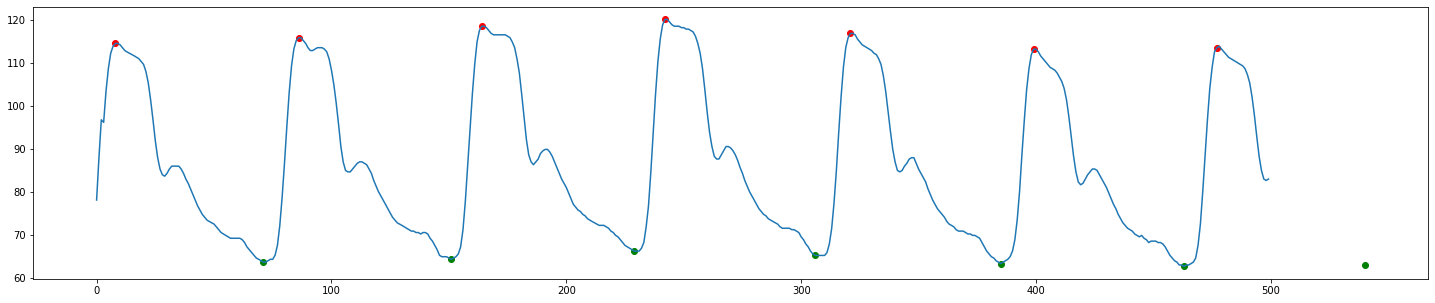

In [13]:
sampleID= 20
NumPeakValley = 7
plt.figure(figsize=(25, 5))
plt.plot(np.arange(0,500,1), DataSmoothed[sampleID][:500])
plt.scatter(PeakIDSet[sampleID][:NumPeakValley], DataSmoothed[sampleID][PeakIDSet[sampleID][:NumPeakValley]], c='red')
plt.scatter(ValleyIDSet[sampleID][:NumPeakValley], DataSmoothed[sampleID][ValleyIDSet[sampleID][:NumPeakValley]], c='green')

# 3.1.1..Map Calculation and Hypotention Detection
#### MAP 계산 및 저혈압 구간 탐지
이론적으로는 65보다 낮은 MAP이 1분이상 지속될 때를 저혈압으로 정의
<br> Smoothing으로 부터 발생하는 에러를 상쇄하기 위해 MAP의 임계값을 하향 조절할(예:64.5) 필요성 있음

In [7]:
DataSmoothed = np.load('../ProcessedData_VitalDB/'+ParaFolder+'/DataSmoothed.npy',allow_pickle = True)
PeakIDSet = np.load('../ProcessedData_VitalDB/'+ParaFolder+'/PeakIDSet.npy',allow_pickle=True)
ValleyIDSet = np.load('../ProcessedData_VitalDB/'+ParaFolder+'/ValleyIDSet.npy',allow_pickle=True)

### Noise detection moduels
#### Noise Detection 하기
- Logic: 
<br> ① Peak to Peak 동일한 길이(100)로 Scaling 하여 구간 설정하고, 구간 내 각각 샘플의 평균값으로부터 오차 5% 이상 되는 Peak 찾기 
<br> ② peak 및 valley에서 N구간(P2PSize)의 평균(Peak / Valley) 값보다 M%(FilterRate)만큼 벗어난 값을 최종 noise로 선정

- Hyper-parameter
<br> - FilterRate: 에러허용 범위(에러 허용범위 낮을 수록 데이터 순결도가 높아지지만 Sample 수가 적어짐)
<br> - P2PSize: 로직 계산시 고려할 peak 및 valley 구간 사이즈 

In [103]:
#FilterRate = 0.15
P2PSize = 20

def FindIDX(IDSet, endIDX):
    IDxSel =  np.where( (IDSet>=startIDX) & (IDSet<=endIDX ))[0]

    if IDSet[IDxSel][-1] < endIDX:
        IDX = IDSet[IDxSel]
    else:
        IDX = IDSet[IDxSel][:-1]
    return IDX


def UnitError (FeatInterval, FeatIDX,FilterRate): # Peak to Peak 동일한 길이(100)로 Scaling 하여 구간 설정하고, 구간 내 각각 샘플의 평균값으로부터 오차 5% 이상 되는 Peak 찾기
    

    # 20 Feat 기준
    FeatIdxVec = np.arange(0, FeatIDX.shape[0] - (P2PSize +1))[..., np.newaxis]
    FeatIdxVec = np.tile(FeatIdxVec, (P2PSize +1))
    FeatIdxVec += np.arange(0, (P2PSize +1))
    FeatIdxVec = FeatIDX[1:][FeatIdxVec] # 처음 peak/valley interval 관련 noise detection 제외

    IntervalIDX = np.concatenate([FeatIdxVec[:, :-1][..., np.newaxis], FeatIdxVec[:, 1:][..., np.newaxis]], axis=-1) 

    ## Feat to Feat Scaling : resampling 100 size per each case
    caseList = []
    for cases in IntervalIDX:
        subcaseList = []
        for subcase in cases:
            subcaseList.append(signal.resample(FeatInterval[subcase[0]:subcase[1]], 100))
        caseList.append(subcaseList)

    ResampleDataSet = np.array(caseList)[:,:,:, 0]     

    ## 평균 비교
    MeanResampleDataSet = np.mean(ResampleDataSet, axis=1, keepdims=True)
    ABSErrors = np.abs(ResampleDataSet - MeanResampleDataSet)
    GreatErrorsIDX = np.where(ABSErrors > MeanResampleDataSet*FilterRate)
   
    ## NOISE 후보구간이 있을 경우만 후보 Feat(peak or valley) 선택
    NoiseCandiFeat = np.array([])
    if len(GreatErrorsIDX[0])>0:
        NoiseCandiFeat = np.unique(IntervalIDX[GreatErrorsIDX[0], GreatErrorsIDX[1]])[..., np.newaxis]

    len(NoiseCandiFeat)
    
    return NoiseCandiFeat


def FeatDiffError (FeatInterval,PeakIDX,ValleyIDX, NoiseCandiPeak,NoiseCandiValley, FilterRate): # peak 및 valley에서 20구간의 평균(Peak / Valley) 값보다 5% 벗어난 값을 최종 noise로 선정
    # ValleyIDX 와 NoiseCandiValley의 관계 map
    ValleyIDXMap = np.where(np.in1d(ValleyIDX, NoiseCandiValley))[0]
    PeakIDXMap = np.where(np.in1d(PeakIDX, NoiseCandiPeak))[0]

    # noise 후보군 peak id 기준으로 이후 27개의 peak
    ## 6000 / 50 (cycle) = 120 bpm, 6000 / 150 (cycle) = 40 bpm 
    ## ((100*20 / 150) + (100*20 / 50) )/2 = 27 
    PeakAVGIDX = np.tile(PeakIDXMap[..., np.newaxis], 20) + np.arange(0, 20)
    PeakAVGIDX = np.minimum(PeakAVGIDX,PeakIDX.shape[0]-1)
    PeakAVGTest = FeatInterval[PeakIDX[PeakAVGIDX]][:,:,0]
    ABSPeakDiff = np.abs(PeakAVGTest[:, 1:] - PeakAVGTest[:, :-1]) 
    ABSPeakDiff = np.concatenate([np.zeros((ABSPeakDiff.shape[0], 1)), ABSPeakDiff], axis=-1)

    # 20개 peak 구간 평균의 5% 의 크기보다 평균에서 벗어난 peak
    CuttPeakNoise =  np.mean(PeakAVGTest, axis=-1)[..., np.newaxis]*FilterRate
    PeakAVGIDX_pad = PeakAVGIDX * (ABSPeakDiff>CuttPeakNoise).astype('int')
    PeakAVGIDX_pad = np.unique(PeakAVGIDX_pad)

    if len(PeakIDX[PeakAVGIDX_pad])>0: # Index zero 처리, candidate 되지 않았다면 0 삭제
        if len(np.intersect1d(NoiseCandiPeak, PeakIDX[PeakAVGIDX_pad][0])) == 0:
            PeakAVGIDX_pad = PeakAVGIDX_pad[1:]
    AnomalyPeakIDX = PeakIDX[PeakAVGIDX_pad]

    # noise 후보군 Valley id 기준으로 이후 20개의 Valley
    ValleyAVGIDX = np.tile(ValleyIDXMap[..., np.newaxis], 20) + np.arange(0, 20)
    ValleyAVGIDX = np.minimum(ValleyAVGIDX,ValleyIDX.shape[0]-1)
    ValleyAVGTest = FeatInterval[ValleyIDX[ValleyAVGIDX]][:,:,0]
    ABSValleyDiff = np.abs(ValleyAVGTest[:, 1:] - ValleyAVGTest[:, :-1]) 
    ABSValleyDiff = np.concatenate([np.zeros((ABSValleyDiff.shape[0], 1)),ABSValleyDiff], axis=-1)

    # 20개 Valley 구간 평균의 5% 의 크기보다 평균에서 벗어난 Valley
    CuttValleyNoise =  np.mean(ValleyAVGTest, axis=-1)[..., np.newaxis]*FilterRate
    ValleyAVGIDX_pad = ValleyAVGIDX * (ABSValleyDiff>CuttValleyNoise).astype('int')
    ValleyAVGIDX_pad = np.unique(ValleyAVGIDX_pad)

    if len(ValleyIDX[ValleyAVGIDX_pad])>0: # Index zero 처리, candidate 되지 않았다면 0 삭제
        if len(np.intersect1d(NoiseCandiValley, ValleyIDX[ValleyAVGIDX_pad][0])) == 0:
            ValleyAVGIDX_pad = ValleyAVGIDX_pad[1:]
    AnomalyValleyIDX = ValleyIDX[ValleyAVGIDX_pad]

    # 최종 Noise idx
    AnomalyIDX =  np.sort(np.concatenate([AnomalyPeakIDX, AnomalyValleyIDX]))
    return AnomalyIDX



###  수집 프로세싱
#### DataSmoothed, PeakIDSet, ValleyIDSet 가 이미 존재하여야함

In [ ]:
TarFilterRate = 0.15
InpFilterRate = 0.20

SkipLen = 15 * 60 * 100 + (90*100)  # 15분 + input 90초 
MaxPerSamp = 10 # 한 sample 당 최대 몇개까지 무작위 추출할지 수 

Yraw = []
Ylabel = []
Ylabel2 = []
Xinput = []
Xlabel = []

Count = 0
for inum, SubData in enumerate(DataSmoothed[0:]):

    print(inum)
    
    PeakIDX = PeakIDSet[inum] # PeakIDset List에서 해당 Peak ID만 선택
    ValleyIDX = ValleyIDSet[inum] # ValleyIDSet List에서 해당 Valley ID만 선택
    
    TargetInterval =  SubData[SkipLen:]

    
    ####------ ------ ------ 무작위 구간 선택 ------ ------ ------####
    if TargetInterval.shape[0] < 2 * 60 * 100: # target 구간이 2분 미만인 경우 제외
        print('target 구간이 2분 미만')
        continue;

    
    Count += 1
    
    # 무작위로 target 구간을 n개 선택할 때, 시작과 끝의 상한하한 점 선택
    UpperLimit = SubData.shape[0] - 61 * 100
    LowerLimit = 17*60*100 # 15분(skip 구간) + 1분30초(투입길이) 보다 넉넉한 candidate 구간

    if LowerLimit >= UpperLimit:
        print('짧은 신호')
        continue;
    
    TargetStartIDX = np.random.randint(LowerLimit, UpperLimit, MaxPerSamp)
    TargetEndIDX = TargetStartIDX + 60 * 100

    for TarStart,TarEnd in zip(TargetStartIDX,TargetEndIDX ):

        # Target 구간
        TargetValleyIDX = ValleyIDX[(ValleyIDX >= TarStart) & (ValleyIDX <= TarEnd)]
        TargetPeakIDX =PeakIDX[(PeakIDX >= TarStart) & (PeakIDX <= TarEnd)]

        # Inp 구간
        InpEnd = TarStart - 15 * 60 * 100 # 15분
        InpStart = InpEnd - 90 * 100 # 90초
        InpValleyIDX = ValleyIDX[(ValleyIDX >= InpStart) & (ValleyIDX <= InpEnd)]
        InpPeakIDX =PeakIDX[(PeakIDX >= InpStart) & (PeakIDX <= InpEnd)]

        if len(SubData[InpStart:InpEnd]) != 9000:
            print('Short in Inp length')
            continue;
    
        
        # Target 구간이 반드시 clean 해야 저혈압 labeling 신뢰성 있음
        TarNoiseCandiPeak = UnitError(SubData,TargetPeakIDX, TarFilterRate ) # Noise 후보 peak
        TarNoiseCandiValley = UnitError(SubData,TargetValleyIDX, TarFilterRate ) # Noise 후보 valley
        TarAnomalyIDList = FeatDiffError(SubData,TargetPeakIDX, TargetValleyIDX, TarNoiseCandiPeak, TarNoiseCandiValley, TarFilterRate)  # peak / valley 20 구간의 error를 통한 noise detection

        Yraw.append(SubData[TarStart:TarEnd])

        ####------ ------ ------ MAP 계산  및 저혈압 레이블링 ------ ------ ------####
        '''
        # 저혈압을 정의하는 target 구간에 노이즈가 있는 경우, MAP 계산 skip
        if  len(TarAnomalyIDList) > 0:
            print('노이즈로 인한 저혈압 판별 불가')
            continue;
        '''
        if  len(TarAnomalyIDList) > 0:
            Ylabel2.append('NoisTar')
        else:
            Ylabel2.append('CleanTar')
            
        
        if TargetPeakIDX.shape[0] > TargetValleyIDX.shape[0]:
            TargetPeakIDX = TargetPeakIDX[:-1]
        elif TargetValleyIDX.shape[0] > TargetPeakIDX.shape[0]:
            TargetValleyIDX = TargetValleyIDX[:-1]
           
        if TargetPeakIDX[1:][0] > TargetValleyIDX[1:][0]: #peak이 valley보다 늦는 경우 # Boundary에 있는 peak / valley는 에러가 있을 수 있기에 index 1부터 시작
            MAPset = np.concatenate([TargetPeakIDX[1:-1][:, np.newaxis], TargetValleyIDX[2:][:, np.newaxis]], axis=-1)
        else:
            MAPset = np.concatenate([TargetPeakIDX[1:][:, np.newaxis], TargetValleyIDX[1:][:, np.newaxis]], axis=-1)
        
        MAPset = MAPset[:-1] # Boundary에 있는 peak / valley는 에러가 있을 수 있기에 마지막 제외

        if np.min(MAPset[:,1] - MAPset[:,0])<0:
            print('error', inum)
            print()
    
        MAPValue = (SubData[MAPset[:, 0]] + SubData[MAPset[:, 1]]*2)/3
        
        if np.sum(MAPValue<=65) / len(MAPValue) == 1 :
            Ylabel.append(['Hypo']) 
            print('Hypo')
        elif np.sum(MAPValue>=75) / len(MAPValue) == 1 :
            Ylabel.append(['NonHypo']) 
            print('NonHypo')
        else:
            Ylabel.append(['GrayZone']) 
            print('그레이존')
            
            



        ####------ ------ ------ 저혈압 Target 구간과 mapping 되는 input 구간 noise 판별 ------ ------ ------####
                
        InpNoiseCandiPeak = UnitError(SubData,InpPeakIDX, InpFilterRate ) # Noise 후보 peak
        InpNoiseCandiValley = UnitError(SubData,InpValleyIDX, InpFilterRate) # Noise 후보 valley
        InpAnomalyIDList = FeatDiffError(SubData,InpPeakIDX,InpValleyIDX, InpNoiseCandiPeak,InpNoiseCandiValley, InpFilterRate)  # peak / valley 20 구간의 error를 통한 noise detection


        Xinput.append(SubData[InpStart:InpEnd]) 

        if len(InpAnomalyIDList) > 0:
            Xlabel.append('NoisInp')
        else:
            Xlabel.append('Clean')

        

    

0
그레이존
그레이존
그레이존
그레이존
그레이존
그레이존
그레이존
그레이존
그레이존
그레이존
1
NonHypo
NonHypo


In [125]:
np.where(np.array(Xlabel) == 'NoisInp')

(array([19, 50], dtype=int64),)

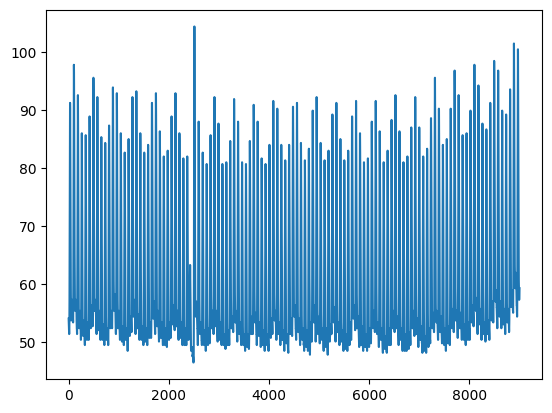

In [127]:
plt.plot(Xinput[50])

In [128]:
np.where(np.array(Ylabel2) == 'NoisTar')

(array([11], dtype=int64),)

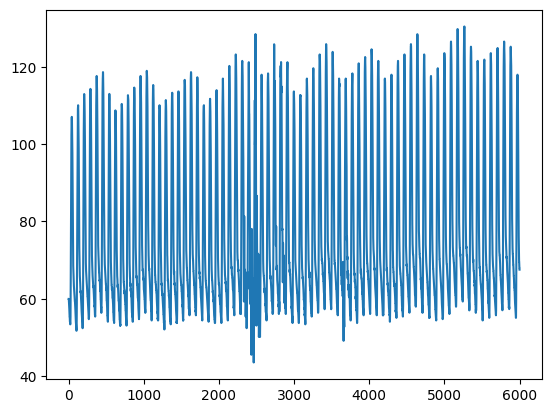

In [129]:
plt.plot(Yraw[11])

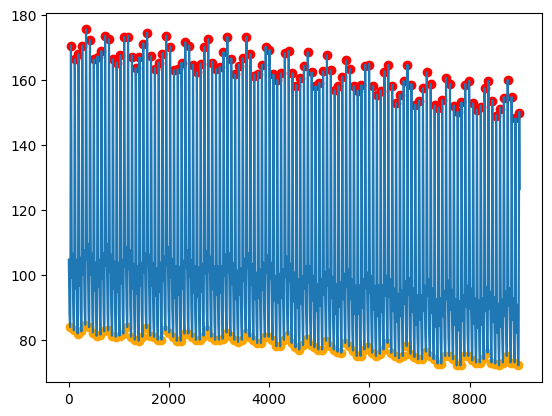

In [60]:
plt.plot(SubData[InpStart:InpEnd] )
plt.scatter(InpPeakIDX-InpStart, SubData[InpPeakIDX], c='red')
plt.scatter(InpValleyIDX-InpStart, SubData[InpValleyIDX], c='orange')

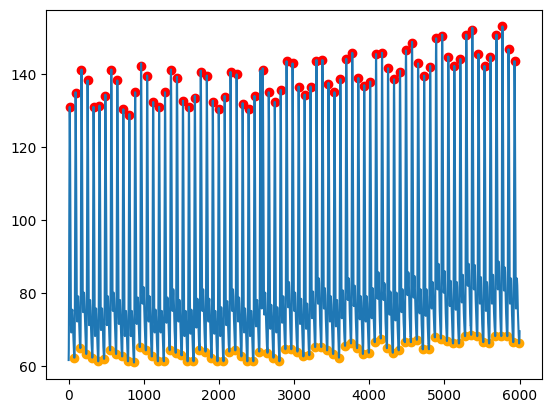

In [61]:
plt.plot(SubData[TarStart:TarEnd] )
plt.scatter(TargetPeakIDX-TarStart, SubData[TargetPeakIDX], c='red')
plt.scatter(TargetValleyIDX-TarStart, SubData[TargetValleyIDX], c='orange')